In [1]:
# 自动计算cell的计算时间
%load_ext autotime

%matplotlib inline
%config InlineBackend.figure_format='svg' #矢量图设置，让绘图更清晰

time: 520 ms (started: 2021-08-21 15:21:10 +08:00)


In [2]:
%%bash

# 增加更新
git add *.ipynb *.md

git remote -v

git commit -m '更新 #1  Aug 21, 2021'

git push origin master

origin	git@github.com:ustchope/eat_tensorflow2_in_30_days.git (fetch)
origin	git@github.com:ustchope/eat_tensorflow2_in_30_days.git (push)
[master 2848813] 更新 #1  Aug 21, 2021
 1 file changed, 405 insertions(+), 10 deletions(-)


To git@github.com:ustchope/eat_tensorflow2_in_30_days.git
   5d5cdc5..2848813  master -> master


time: 8.17 s (started: 2021-08-21 15:21:11 +08:00)


In [4]:
#设置使用的gpu
import tensorflow as tf
from tensorflow import keras

gpus = tf.config.list_physical_devices("GPU")

if gpus:
   
    gpu0 = gpus[0] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    # 或者也可以设置GPU显存为固定使用量(例如：4G)
    #tf.config.experimental.set_virtual_device_configuration(gpu0,
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) 
    tf.config.set_visible_devices([gpu0],"GPU")

time: 1.15 ms (started: 2021-08-21 15:21:52 +08:00)


# 设置

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

time: 722 µs (started: 2021-08-21 15:21:59 +08:00)


# 简介

本指南涵盖使用内置 API 进行训练和验证（例如 `Model.fit()`、`Model.evaluate()` 和 `Model.predict()`）时的训练、评估和预测（推理）模型。

如果您对在指定自己的训练步骤函数时利用 `fit()` 感兴趣，请参阅自定义 `fit()` 指南。

如果您有兴趣从头开始编写自己的训练和评估循环，请参阅“从头开始编写训练循环”指南。

一般来说，无论您是使用内置循环还是编写自己的循环，模型训练和评估在每种 Keras 模型中都严格按照相同的方式进行——顺序模型、使用功能 API 构建的模型以及通过以下方式从头开始编写的模型 模型子类化。

本指南不包括分布式训练，这在我们的多 GPU 和分布式训练指南中有所介绍。

# API 概述：第一个端到端示例

将数据传递给模型的内置训练循环时，您应该使用 NumPy 数组（如果您的数据很小并且适合内存）或 tf.data 数据集对象。 在接下来的几段中，我们将使用 MNIST 数据集作为 NumPy 数组，以演示如何使用优化器、损失和指标。

让我们考虑以下模型（在这里，我们使用 Functional API 构建，但它也可以是 Sequential 模型或子类模型）：

In [6]:
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

time: 1.48 s (started: 2021-08-21 15:22:02 +08:00)


In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
digits (InputLayer)          [(None, 784)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
predictions (Dense)          (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________
time: 4.22 ms (started: 2021-08-21 15:11:08 +08:00)


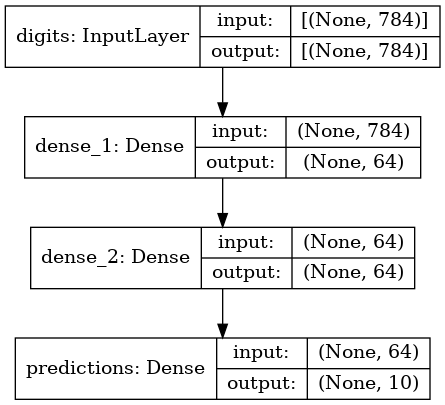

time: 6.93 s (started: 2021-08-21 15:13:47 +08:00)


In [10]:
plot_model(model, show_shapes=True)

以下是典型的端到端工作流程，包括：
* 训练
* 对从原始训练数据生成的保留集进行验证
* 对测试数据的评估

我们将在此示例中使用 MNIST 数据。

In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data (these are NumPy arrays)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

time: 430 ms (started: 2021-08-21 15:22:06 +08:00)


我们指定训练配置（优化器、损失、指标）：

In [8]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

time: 19.9 ms (started: 2021-08-21 15:22:07 +08:00)


我们调用 fit()，它将通过将数据切成大小为 batch_size 的“批次”来训练模型，并在给定数量的 epoch 中重复迭代整个数据集。

In [10]:
print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=20,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

Fit model on training data
Epoch 1/20
782/782 [==============================] - 7s 9ms/step - loss: 0.0665 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.1046 - val_sparse_categorical_accuracy: 0.9694
Epoch 2/20
782/782 [==============================] - 7s 9ms/step - loss: 0.0583 - sparse_categorical_accuracy: 0.9823 - val_loss: 0.1017 - val_sparse_categorical_accuracy: 0.9738
Epoch 3/20
782/782 [==============================] - 7s 9ms/step - loss: 0.0510 - sparse_categorical_accuracy: 0.9843 - val_loss: 0.0985 - val_sparse_categorical_accuracy: 0.9747
Epoch 4/20
782/782 [==============================] - 7s 9ms/step - loss: 0.0442 - sparse_categorical_accuracy: 0.9873 - val_loss: 0.1014 - val_sparse_categorical_accuracy: 0.9734
Epoch 5/20
782/782 [==============================] - 7s 9ms/step - loss: 0.0388 - sparse_categorical_accuracy: 0.9884 - val_loss: 0.1074 - val_sparse_categorical_accuracy: 0.9715
Epoch 6/20
782/782 [==============================] - 7s 9ms/step - loss:

返回的历史对象保存了训练期间损失值和度量值的记录：

In [11]:
history.history

{'loss': [0.06649843603372574,
  0.05826172977685928,
  0.05100547522306442,
  0.04415423795580864,
  0.03883035108447075,
  0.03441018983721733,
  0.029938992112874985,
  0.02597038261592388,
  0.02442266047000885,
  0.02133406326174736,
  0.018334824591875076,
  0.01701589673757553,
  0.015719568356871605,
  0.012882999144494534,
  0.012036602944135666,
  0.010108149610459805,
  0.009029699489474297,
  0.007908957079052925,
  0.008356831967830658,
  0.006960942409932613],
 'sparse_categorical_accuracy': [0.9801599979400635,
  0.98225998878479,
  0.9843400120735168,
  0.9873200058937073,
  0.9884399771690369,
  0.9891999959945679,
  0.9907199740409851,
  0.9918400049209595,
  0.992579996585846,
  0.993179976940155,
  0.994159996509552,
  0.9944999814033508,
  0.9945600032806396,
  0.9963200092315674,
  0.9960399866104126,
  0.9965000152587891,
  0.9969199895858765,
  0.9975200295448303,
  0.997160017490387,
  0.9976599812507629],
 'val_loss': [0.10455715656280518,
  0.1017419770359993

time: 9.83 ms (started: 2021-08-21 15:25:36 +08:00)


In [12]:
import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

time: 2.01 ms (started: 2021-08-21 15:25:42 +08:00)


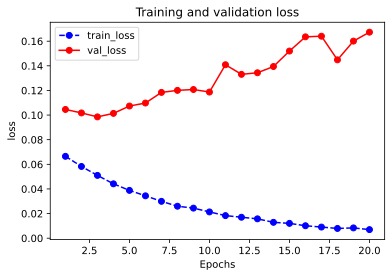

time: 250 ms (started: 2021-08-21 15:25:43 +08:00)


In [13]:
plot_metric(history,"loss")

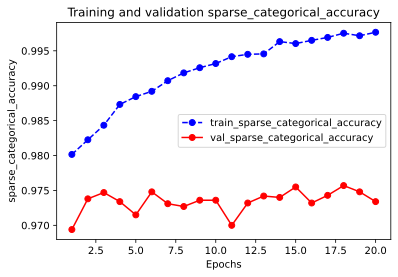

time: 236 ms (started: 2021-08-21 15:26:09 +08:00)


In [14]:
plot_metric(history,"sparse_categorical_accuracy")

我们通过`evaluate()`在测试数据上评估模型：

In [16]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
79/79 [==============================] - 1s 7ms/step - loss: 0.1608 - sparse_categorical_accuracy: 0.9730
test loss, test acc: [0.1607811003923416, 0.9729999899864197]
time: 679 ms (started: 2021-08-21 15:27:56 +08:00)


In [17]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)

Generate predictions for 3 samples
predictions shape: (3, 10)
time: 65.9 ms (started: 2021-08-21 15:27:59 +08:00)


现在，让我们详细回顾一下这个工作流程的每一部分。

# compile() 方法：指定损失、指标和优化器

要使用 fit() 训练模型，您需要指定损失函数、优化器以及可选的一些要监控的指标。

您将这些作为 compile() 方法的参数传递给模型：

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

指标参数应该是一个列表——你的模型可以有任意数量的指标。

如果您的模型有多个输出，您可以为每个输出指定不同的损失和度量，并且您可以调整每个输出对模型总损失的贡献。 您将在将数据传递到多输入、多输出模型部分中找到有关此的更多详细信息。

请注意，如果您对默认设置感到满意，在许多情况下，可以通过字符串标识符作为快捷方式指定优化器、损失和指标：

In [ ]:
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

为了以后重用，让我们把我们的模型定义和编译步骤放在函数中； 我们将在本指南中的不同示例中多次调用它们。

In [18]:
def get_uncompiled_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(64, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    return model

time: 1.87 ms (started: 2021-08-21 15:31:22 +08:00)


## 许多内置优化器、损失和指标可用

一般来说，您不必从头开始创建自己的损失、指标或优化器，因为您需要的可能已经是 Keras API 的一部分：

优化器：
* SGD()（有或没有动量）
* RMSprop()
* Adam()
等。

损失：
* MeanSquaredError()
* KLDivergence()
* CosineSimilarity()
* etc.

度量：
* AUC()
* Precision()
* Recall()
* etc.

## 自定义损失

如果您需要创建自定义损失，Keras 提供了两种方法。

第一种方法涉及创建一个接受输入 y_true 和 y_pred 的函数。 以下示例显示了一个计算真实数据和预测之间的均方误差的损失函数：

In [19]:
def custom_mean_squared_error(y_true, y_pred):
    return tf.math.reduce_mean(tf.square(y_true - y_pred))


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=custom_mean_squared_error)

# We need to one-hot encode the labels to use MSE
y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

782/782 [==============================] - 7s 9ms/step - loss: 0.0163


time: 7.33 s (started: 2021-08-21 15:35:19 +08:00)


如果您需要一个接受 `y_true` 和 `y_pred` 旁边参数的损失函数，您可以子类化 `tf.keras.losses.Loss` 类并实现以下两个方法：
* `__init__(self)`：接受在调用损失函数期间传递的参数
* `call(self, y_true, y_pred)`: 使用目标 (`y_true`) 和模型预测 (`y_pred`) 来计算模型的损失

假设您想使用均方误差，但增加了一项将使预测值远离 0.5（我们假设分类目标是单热编码并采用 0 和 1 之间的值）。 这会激励模型不要过于自信，这可能有助于减少过度拟合（我们不知道它是否有效，直到我们尝试！）。

以下是您的操作方法：

In [20]:
class CustomMSE(keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, name="custom_mse"):
        super().__init__(name=name)
        self.regularization_factor = regularization_factor

    def call(self, y_true, y_pred):
        mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
        reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
        return mse + reg * self.regularization_factor


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=CustomMSE())

y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

782/782 [==============================] - 7s 9ms/step - loss: 0.0390


time: 7.35 s (started: 2021-08-21 15:37:45 +08:00)


## 自定义指标

如果您需要一个不属于 API 的指标，您可以通过继承 `tf.keras.metrics.Metric` 类轻松创建自定义指标。 您将需要实现 4 种方法：
* `__init__(self)`，您将在其中为您的指标创建状态变量。
* `update_state(self, y_true, y_pred, sample_weight=None)`，它使用目标 `y_true` 和模型预测 `y_pred` 来更新状态变量。
* `result(self)`，它使用状态变量来计算最终结果。
* `reset_states(self)`，它重新初始化指标的状态。